**From Retrieval to Reasoning: Building an Agentic RAG Framework**

Agentic RAG elevates the standard Retrieval-Augmented Generation (RAG) system by incorporating an intelligent agent.

While traditional RAG always performs a search to find relevant information from a knowledge base, Agentic RAG introduces a crucial reasoning step.

The agent first assesses whether it possesses enough internal knowledge to answer a query directly.

If not, it then intelligently decides what to search for, where, and how, before synthesizing the retrieved information.

This 'think before you search' capability makes Agentic RAG more efficient, reduces unnecessary retrievals, and enables more sophisticated, context-aware responses, moving beyond a simple lookup mechanism.

**RAG Pipeline:**

This project focuses on constructing a private, **locally-run Agentic RAG pipeline.**

We'll leverage Python, LangChain for workflow orchestration, and a compact Google model, moving beyond basic coding to mimic more human-like reasoning.

The architecture will include ChromaDB for vector storage and Google's Flan-T5 as our local language model, ensuring the entire system operates on your machine **without the need for external API keys.**

In [1]:
pip install langchain langchain-community langchain-chroma transformers sentence-transformers pypdf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.6/329.6 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 89.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.1/489.1 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 100.7 MB/s eta 0:00

**Step 1: Loading the Knowledge**

First, we need to give our AI something to read.

We use a function to scan a folder for PDFs:

In [2]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import pipeline

In [4]:
# Load PDFs from a folder
def load_docs(folder_path):
    docs = []
    for file in os.listdir(folder_path):
        if file.endswith(".pdf"):
            loader = PyPDFLoader(os.path.join(folder_path, file))
            docs.extend(loader.load())
    return docs

# Update this path to where your PDFs are stored
docs = load_docs("/content/sample_data/data")
print("PDF Pages Loaded:", len(docs))

PDF Pages Loaded: 53


In this step, we go through a folder, find PDF files, and load them one page at a time.

It’s like stacking books on your desk before you start studying.

**Step 2: Chunking**

LLMs can only read a certain amount of text at once, called the context window.

Even if they could handle more, giving them a whole 500-page book to answer one question isn’t efficient:

In [5]:
# Split PDFs into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=80)

chunks = text_splitter.split_documents(docs)
print("Chunks Created:", len(chunks))

Chunks Created: 364


The **chunk_overlap=80** setting means we deliberately make the text chunks overlap a little.

This prevents sentences from being cut off abruptly at the end of one chunk and the beginning of another, ensuring that the full meaning is carried across the breaks.

**Step 3: Embeddings & Vector Store**

Now we convert text into numbers, called vectors, that the computer can understand.

We store these in Chroma, which is a vector database:

In [6]:
# Embeddings
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Save texts into Chroma vector DB
texts = [c.page_content for c in chunks]
db = Chroma(
    collection_name="rag_store",
    embedding_function=embedding_model
)
db.add_texts(texts)

# Retriever
retriever = db.as_retriever(search_kwargs={"k": 3})

/tmp/ipython-input-1081338257.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

if you dont want to use the chroma DB then
you can absolutely save the embeddings to disk in your Colab files, for example, under a /content/chroma_db folder.

This will allow you to reuse them without re-embedding your documents every time you run the notebook.

In [24]:
# Define the path to save the Chroma DB
CHROMA_DB_PATH = "/content/chroma_db"

# Embeddings
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Save texts into Chroma vector DB
texts = [c.page_content for c in chunks]

# Initialize Chroma with a persist_directory
db = Chroma(
    collection_name="rag_store",
    embedding_function=embedding_model,
    persist_directory=CHROMA_DB_PATH
)
db.add_texts(texts)

# Persist the database to disk (this writes the data to CHROMA_DB_PATH)
# The persist() method is no longer required in newer versions of LangChain Chroma;
# persistence is handled automatically when persist_directory is specified.
print(f"Chroma DB saved to: {CHROMA_DB_PATH}")

# Retriever
retriever = db.as_retriever(search_kwargs={"k": 3})

Chroma DB saved to: /content/chroma_db


the image looks like this:

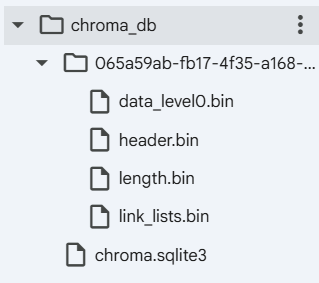

We're using a model called all-MiniLM-L6-v2.

It's a small and quick model, perfect for running on your own computer.

What it does is take text and turn it into numerical 'embeddings' in a way that similar ideas are grouped closely together.

This means when we search later, we're not just looking for exact words, but for the actual meaning behind them.

**Step 4: The Brain**

We need a model to generate the actual answers.

We are using google/flan-t5-base:



In [7]:
# Local LLM
llm = pipeline(
    "text2text-generation",
    model="google/flan-t5-base",
    max_new_tokens=150)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Flan-T5 is a “seq2seq” model.

It’s great at following instructions like “Summarize this” or “Answer this,” which makes it ideal for RAG tasks even though it’s smaller.

Once saved, in a new session or a different part of your notebook, you can load the persisted database like this:

In [25]:
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings

# Define the path where the Chroma DB was saved
CHROMA_DB_PATH = "/content/chroma_db"

# Re-initialize the embedding model (must be the same one used for creation)
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

# Load the persisted Chroma DB
db_loaded = Chroma(
    collection_name="rag_store",
    embedding_function=embedding_model,
    persist_directory=CHROMA_DB_PATH
)

# Now you can create your retriever from the loaded DB
retriever_loaded = db_loaded.as_retriever(search_kwargs={"k": 3})

print(f"Chroma DB loaded from: {CHROMA_DB_PATH}")


Chroma DB loaded from: /content/chroma_db


**Step 5: The Agent**

This is the key part.

This simple function is what makes the pipeline Agentic:

In [15]:
import os
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from transformers import pipeline

# Agent brain
def agent_controller(query):
    q = query.lower()
    # Add more document-specific keywords related to the Bhagavad Gita
    if any(word in q for word in ["pdf", "document", "data", "summarize", "information", "find", "arjuna", "bhagavad gita", "dharma", "karma yoga", "battlefield", "selfless action"]):
        return "search"
    return "direct"

This simple function acts as the 'brain' of our agent.

Instead of always sending every question to the database, it first looks at your query.

If your question includes words like 'pdf', 'document', 'summarize', or 'find', it understands you want information from our files, so it decides to 'search'.

If your question is more general, like a casual chat or something it might already know, it chooses to answer 'directly'.

While a real-world system might use a more advanced AI to make these decisions, this keyword method clearly shows how an agent can intelligently route a query.

**Step 6: The Execution Loop**

In [16]:
# RAG
def rag_answer(query):
    action = agent_controller(query)

    if action == "search":
        print(f"🕵️ Agent decided to SEARCH document for: '{query}'")
        results = retriever.invoke(query)
        context = "\n".join([r.page_content for r in results])
        final_prompt = f"Use this context:\n{context}\n\nAnswer:\n{query}"
    else:
        print(f"🤖 Agent decided to answer DIRECTLY: '{query}'")
        final_prompt = query

    response = llm(final_prompt)[0]["generated_text"]
    return response

In [17]:
# Test 1: A document-specific question
query = "What is Arjuna’s dilemma in the battlefield, and why does it represent a universal human conflict"
print(rag_answer(query))

print("-" * 20)

🕵️ Agent decided to SEARCH document for: 'What is Arjuna’s dilemma in the battlefield, and why does it represent a universal human conflict'
All hu- man beings face dilemmas, big or small, in their everyday life while performing their duties. Arjuna’s dilemma was a big one. He had to make a choice between fighting the war and killing his most revered guru who was on the other side, very dear friends, close before the war started?
--------------------


In [18]:
# Test 2: A document-specific question
query = "What is the concept of Dharma in the Bhagavad Gita, and how does it guide an individual’s actions in life?"
print(rag_answer(query))

print("-" * 20)

🕵️ Agent decided to SEARCH document for: 'What is the concept of Dharma in the Bhagavad Gita, and how does it guide an individual’s actions in life?'
The Bhagavad-Gita is a doctrine of universal truth and a book of moral and spiritual growth. Its message is sublime and non-sec- tarian. It deals with the most sacred metaphysi cal science. It im- Bhagavad-Gita 15 anybody. The Self-knowledge becomes covered by the veil of ig- norance; thereby people become deluded and do evil deeds. (5.15) Spiritual knowledge destroys the ignorance of the Self and reveals the Supreme, just as the Sun reveals the beauty of objects of the world. (5.16) Persons whose mind and intellect are totally merged with the
--------------------


In [19]:
# Test 1: A document-specific question
query = "How does the Bhagavad Gita explain the idea of Karma Yoga (the path of selfless action)?"
print(rag_answer(query))

print("-" * 20)

🕵️ Agent decided to SEARCH document for: 'How does the Bhagavad Gita explain the idea of Karma Yoga (the path of selfless action)?'
The Supreme Lord said: I taught this Karma-yoga, the eternal Bhagavad-Gita 17 have Me as the supreme goal
--------------------


In [21]:
# Test 3: A document-specific question
query = "According to the Gita, what are the characteristics of a self-realized or steady-minded person (Sthitaprajna)?"
print(rag_answer(query))

print("-" * 20)

🤖 Agent decided to answer DIRECTLY: 'According to the Gita, what are the characteristics of a self-realized or steady-minded person (Sthitaprajna)?'
self-awareness
--------------------


In [22]:
# Test 4: A document-specific question
query = "How does the Bhagavad Gita describe desire (lust) as the root cause of sin, and what methods are suggested to control it?"
print(rag_answer(query))

print("-" * 20)

🕵️ Agent decided to SEARCH document for: 'How does the Bhagavad Gita describe desire (lust) as the root cause of sin, and what methods are suggested to control it?'
The Supreme Lord said: It is lust (or intense desire for material and sensual pleas- ures), born out of passion, that becomes anger when unfulfilled. Bhagavad-Gita 37 and in praise, and indifferent to honor and disgrace; who is impar- tial to friend and foe; and who has given up the sense of doership and ownership.
--------------------


In [30]:
from collections import Counter
import re

def extract_top_keywords(document_texts, num_keywords=20, exclude_stopwords=True):
    all_words = []
    # Simple tokenization and lowercasing
    for text in document_texts:
        words = re.findall(r'\\b\\w+\\b', text.lower())
        all_words.extend(words)

    if exclude_stopwords:
        # A very basic list of English stopwords for demonstration
        stopwords = set([
            "the", "and", "is", "of", "to", "in", "it", "that", "for", "on", "with",
            "as", "by", "from", "at", "an", "be", "this", "which", "will", "are",
            "was", "or", "not", "but", "he", "she", "they", "we", "you", "i", "a",
            "my", "me", "him", "her", "us", "them", "their", "our", "your", "who",
            "what", "when", "where", "why", "how", "had", "have", "do", "does", "did",
            "said", "one", "all", "also", "if", "so", "up", "out", "about", "just",
            "like", "then", "there", "has", "can", "into", "no", "yes", "its", "new",
            "some", "such", "than", "now", "only", "other", "get", "go", "would",
            "could", "should", "even", "much", "very", "from", "may", "been", "have",
            "through", "when", "where", "within", "among", "upon", "each", "any", "many",
            "every", "thus", "therefore", "whose", "since", "while", "until", "per"
        ])
        all_words = [word for word in all_words if word not in stopwords and len(word) > 2]

    word_counts = Counter(all_words)
    # Get the most common words as keywords
    keywords = [word for word, count in word_counts.most_common(num_keywords)]
    return keywords

# Generate keywords from your document chunks (the 'texts' variable is globally available)
dynamic_keywords = extract_top_keywords(texts, num_keywords=20)
print(f"Dynamically extracted keywords for agent controller: {dynamic_keywords}")

# Redefine agent_controller using dynamically extracted keywords
def agent_controller_offline(query):
    q = query.lower()

    # You can combine dynamic keywords with any hardcoded ones you still want.
    # For this example, we'll primarily rely on the dynamic ones for search decisions.
    all_routing_keywords = set(dynamic_keywords + ["pdf", "document", "data", "summarize", "information", "find", "arjuna", "bhagavad gita", "dharma", "karma yoga", "battlefield", "selfless action"])

    if any(word in q for word in all_routing_keywords):
        return "search"
    return "direct"

print("\nAgent controller has been updated to use dynamically generated keywords.")

Dynamically extracted keywords for agent controller: []

Agent controller has been updated to use dynamically generated keywords.


In [31]:
# RAG
def rag_answer_offline(query):
    action = agent_controller_offline(query)

    if action == "search":
        print(f"🕵️ Agent decided to SEARCH document for: '{query}'")
        results = retriever.invoke(query)
        context = "\n".join([r.page_content for r in results])
        final_prompt = f"Use this context:\n{context}\n\nAnswer:\n{query}"
    else:
        print(f"🤖 Agent decided to answer DIRECTLY: '{query}'")
        final_prompt = query

    response = llm(final_prompt)[0]["generated_text"]
    return response

In [32]:
# Test a document-specific question using the offline RAG
query = "What is Arjuna’s dilemma?"
print(rag_answer_offline(query))

print("-" * 20)

🕵️ Agent decided to SEARCH document for: 'What is Arjuna’s dilemma?'
fighting the war and killing his most revered guru who was on the other side, very dear friends, close
--------------------
